<font color=black><h1> Assumption & Performance Testing for Regression & ARIMA Model</h1></font>

Breaking linear model assumptions into two parts:-
- According to Gauss Markov Theorem, in a linear regression model a ordinary least square model gives Best Linear Unbiased       Estimator(BLUE) when following assumptions are met:-<br>
 - __Linearity__ - The independent variables should vary linearly with target variable. This means the parameters(coefficients    & error terms) of variable should be constant
 - __Randomness__ - data used for building model should be a random sample of the population
 - __Non-Collinearity__ - The independendent variables should not be inter correlated.This is because in linear regression we
   predict change in target variable with one unit change in each independent variable with other variables kept constant
   and if independent variables are correlated on changing other variables will also change.
 - __Endogeneity__ - The regressors should not be correlated with error term. Error represent the unexplained variance.
   If independent variables are correlated to error terms then independent variable can be used to predict error term which is 
   fundamentally wrong.
 - __No Hetroscedaticity__ - the variance of the error terms should be constant.<br>

- Other Assumptions:-<br>
 - Residuals should not be correlated to each other i.e. No Autocorrelation - Residuals of one observation should not predict 
   Residual of next observation
 - Residuals should be normally distributed
 - Expectation or mean of residuals should be zero

In [162]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import numpy as np
import statsmodels.tsa.api as smt
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_absolute_error as mae
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.stats.diagnostic import acorr_breusch_godfrey as abg
from statsmodels.tsa.arima_model import ARIMA
from arch.unitroot import PhillipsPerron

In [163]:
import os
os.chdir("C:/Users/mehul/Downloads")

<h4> Function for assumption & performance testing </h4>

In [171]:

def linear_model(data,type_model,target,order=0):
    Results = pd.DataFrame({},index=[])
    
    def data_description(df):
        print("First Few Obeservations in Dataset")
        print(df.head(10))
        print("------------------------------------------------------------------------------")
        print("Dataset Description")
        print(df.describe())
        print("------------------------------------------------------------------------------")
        
    def missing_value(df):
        print("Checking Null Values")
        print(df.info())
        print("------------------------------------------------------------------------------")
        print("Checking NA Values")
        print(df.isna().sum())
        print("------------------------------------------------------------------------------")
        print("Replacing NA values with Median Value")
        for column in df.columns:
            if df[column].isna().any():
                df[column].fillna(df[column].median(), inplace=True)
        print(df.info())
        print("------------------------------------------------------------------------------")
        return df
    
    def model(alg,df,target,X_train,Y_train):
            alg.fit(X_train,Y_train)
            print(f'Coefficients: {alg.coef_}')
            print(f'Intercept: {alg.intercept_}')
            print(f'R^2 score: {alg.score(X_train, Y_train)}')
    
    def performance(model,Y_train,type_model):
        if type_model == 2:
            print("Adjusted R squred")
            adj_r = model.rsquared_adj
            Results["Performance Test"] = 'Result'
            Results["Adjusted R squared"] = [adj_r]
            print(adj_r)
            print("------------------------------------------------------------------------------")
            print("Mean Squared Error")
            mse = model.mse_model
            Results["Mean Squared Error"] = [mse]
            print(mse)
            print("------------------------------------------------------------------------------")
            print("Root Mean Squared Error")
            rmse = np.sqrt(model.mse_model)
            Results["Root Mean Squared Error"] = [rmse]
            print(rmse)
            print("------------------------------------------------------------------------------")
            print("Mean Absolute Error")
            pred = model.predict()
            MAE = mae(Y_train,pred)
            Results["Mean Absolute Error"] = [MAE]
            print(MAE)
            print("------------------------------------------------------------------------------")
            print("Mean Absolute Perecentage Error")
            #y_true, y_pred = check_arrays(Y_train,pred)
            mape = np.mean(np.abs((Y_train- pred) / Y_train)) * 100
            Results["Mean Absolute Perecentage Error"] = [mape]
            print(mape)
            return Results
        
        if type_model == 3:
            print("------------------------------------------------------------------------------")
            Results["Performance Test"] = 'Result'
            print("Mean Squared Error")
            mse = ((Y_train-model.fittedvalues)**2).mean()
            Results["Mean Squared Error"] = [mse]
            print(mse)
            print("------------------------------------------------------------------------------")
            print("Root Mean Squared Error")
            rmse = np.sqrt(mse)
            Results["Root Mean Squared Error"] = [rmse]
            print(rmse)
            print("------------------------------------------------------------------------------")
            print("Mean Absolute Error")
            MAE = (model.resid).mean()
            Results["Mean Absolute Error"] = [MAE]
            print(MAE)
            print("------------------------------------------------------------------------------")
            print("Mean Absolute Perecentage Error")
            #y_true, y_pred = check_arrays(Y_train,pred)
            mape = np.mean(np.abs((model.resid) / Y_train)) * 100
            Results["Mean Absolute Perecentage Error"] = [mape]
            print(mape)
            return Results
        
    def linearity_test(model,y):
        %matplotlib inline
        sns.set_style('darkgrid')
        sns.mpl.rcParams['figure.figsize'] = (15.0,9.0)
        fitted_vals = model.predict()
        resids = model.resid
        fig, ax = plt.subplots(1,2)
        sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
        ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
        ax[0].set(xlabel='Predicted', ylabel='Observed')
        sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
        ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
        ax[1].set(xlabel='Predicted', ylabel='Residuals')
        plt.show()
        
    def mean_resid(model):
        print(model.resid.mean())
    
    def multicol_test(X_constant,X,Results):
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
        Results['Multicollinearity Test'] = 'Result'
        Results["Variable"] = 'VIF'
        vif_res = pd.DataFrame({0 : vif[1:]}, index=X.columns)
        Result_vif = pd.concat([Results.transpose(),vif_res],axis=0,sort=False)
        print(vif_res)
        return Result_vif
    
    def hetroscedasticity_test(model,Results):
        fitted_vals = model.predict()
        resids = model.resid
        resids_standardized = model.get_influence().resid_studentized_internal
        bp = sms.het_breuschpagan(resids, model.model.exog)
        bp_test = pd.DataFrame({"Breusch-Pagan test":"Value",'Lagrange multiplier statistic':bp[0],
                               'p-value':bp[1],'f-value':bp[2],'f p-value':bp[3]},index=[0])
        Results["Hetroscedasticity Test"] = 'Result'
        Result_hetro = pd.concat([Results,bp_test],axis=1,sort=False)
        gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                               columns=['value'],index=['F statistic', 'p-value'])
        print('\n Breusch-Pagan test ----')
        print(bp_test)
        print('\n Goldfeld-Quandt test ----')
        print(gq_test)
        print('\n Residuals plots ----')
        %matplotlib inline
        sns.set_style('darkgrid')
        sns.mpl.rcParams['figure.figsize'] = (15.0,9.0)
        fig, ax = plt.subplots(1,2)
        sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
        ax[0].set_title('Residuals vs Fitted', fontsize=16)   
        ax[0].set(xlabel='Fitted Values', ylabel='Residuals')
        sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
        ax[1].set_title('Scale-Location', fontsize=16)
        ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')
        plt.show()
        return Result_hetro
    
    def autocorrelation(model,Result):
        %matplotlib inline
        print("Durbin-Watson Test Result")
        print(durbin_watson(model.resid, axis=0))
        print("------------------------------------------------------------------------------")
        print("Breusch Godfrey Test")
        bg_test = abg(model)
        Result["Autocorrelation Test"] = 'Result'
        Result_bg = pd.DataFrame({"Breusch Godfrey Test":"Value","Lagrange multiplier test statistic":bg_test[0],
                                  "p-value Lagrange multiplier test":bg_test[1],"fstatistic":bg_test[2],"p-value Ftest":bg_test[3]},index=[0])
        Result_auto = pd.concat([Result,Result_bg],axis=1,sort=False)
        print(Result_bg.transpose())
        print("------------------------------------------------------------------------------")
        fig, ax = plt.subplots(figsize=(18,9))
        acf = smt.graphics.plot_acf(model.resid, lags=40 , alpha=0.05,ax=ax)
        acf.show()
        plt.show()
        return Result_auto
        
        
    def resid_var_corr(model,X_train):
        from scipy.stats.stats import pearsonr
        for column in X_train.columns:
            corr_test = pearsonr(X_train[column],model.resid)
            print(f'Variable :{column} ---- Correlation:{corr_test[0]:.4f},P_value:{corr_test[1]:.4f}')
            
    def normality_test(model,Result):
        jb = stats.jarque_bera(model.resid)
        sw = stats.shapiro(model.resid)
        Result["Normality Test"] = 'Result'
        Result["SW Test Result"] = 'Value'
        Result["Test Stats"] = [sw[0]]
        Result["p-Value -Test Statistic"] = [sw[1]]
        ad = stats.anderson(model.resid,dist ='norm')
        ks = stats.kstest(model.resid,'norm')
        print(f'Jarque Bera Test ------- Statistic :{jb[0]:.4f},P_value :{jb[1]:.4f}')
        print(f'Shapiro-Wilk Test ------- Statistic :{sw[0]:.4f},P_value :{sw[1]:.4f}')
        print(f'Kolmogrov-Smirnov Test ------- Statistic :{ks[0]:.4f},P_value :{ks[1]:.4f}')
        print(f'Anderson-Darling Test ------- Statistic :{ad[0]:.4f},5% Critical Value :{ad.critical_values[2]:.4f}')
        %matplotlib inline
        fig, ax = plt.subplots(figsize=(18,9))
        sm.ProbPlot(model.resid).qqplot(line='s',ax=ax)
        plt.title("Q-Q Plot")
        plt.show()
        return Result
    
    def stationarity_test(ts,target,Results):
        print('Results of Dickey-Fuller Test:')
        dftest = adfuller(ts[target])
        Results["Stationarity Test"] = 'Result'
        dfoutput = pd.DataFrame({'Dickey Fuller Test' :'Result','Test Statistic': dftest[0],'p-value':dftest[1],'#Lags Used':dftest[2],'Number of Observations Used':dftest[3]},index = [0])
        result = dftest[4]
        for key,Value in result.items():
            dfoutput['Critical Value(%s)'%key] = [Value]
        Result = pd.concat([Results,dfoutput],axis=1,sort=False)
        print(dfoutput.transpose())
        print("------------------------------------------------------------------------------")
        print ('Results of KPSS Test:')
        kpsstest = kpss(ts[target], regression='c')
        kpss_output = pd.DataFrame({'KPSS Test': 'Result','Test Statistic':kpsstest[0],'p-value':kpsstest[1],'Lags Used':kpsstest[2]},index=[0])
        for key,value in kpsstest[3].items():
            kpss_output['Critical Value(%s)'%key] = [value]
        Result = pd.concat([Result,kpss_output],axis=1,sort=False)
        print (kpss_output.transpose())
        print("------------------------------------------------------------------------------")
        print ('Results of Phillips-Perron Test:')
        pptest = PhillipsPerron(ts[target])
        pp_output = pd.DataFrame({'Phillips-Perron Test': 'Result','Test Statistic':pptest.stat,'p-value':pptest.pvalue,
                                  'Lags Used':pptest.lags},index=[0])
        for key,value in pptest.critical_values.items():
            pp_output['Critical Value(%s)'%key] = [value]
        Result = pd.concat([Result,pp_output],axis=1,sort=False)
        print(pptest)
        print("------------------------------------------------------------------------------")
        return Result
    
    if type_model==1:
        from sklearn.linear_model import LinearRegression
        alg = LinearRegression()
        model(alg,df,target,X_train,Y_train)
    elif type_model==2:
        df = pd.read_csv(data)
        data_description(df)
        print("------------------------------------------------------------------------------")
        df = missing_value(df)
        print("------------------------------------------------------------------------------")
        y = df[target]
        x = df.loc[:,df.columns != target]
        from sklearn.model_selection import train_test_split
        X_train,X_test,Y_train,Y_test = train_test_split(x,y,random_state=42,test_size = 0.3,shuffle= True)
        X_constant = sm.add_constant(X_train)
        lin_reg = sm.OLS(Y_train,X_constant).fit()
        print(lin_reg.summary())
        print("------------------------------------------------------------------------------")
        print("Performance Testing")
        Results = performance(lin_reg,Y_train,type_model)
        print("------------------------------------------------------------------------------")
        print("Normality of Residuals")
        Result_norm = normality_test(lin_reg,Results)
        print("------------------------------------------------------------------------------")
        print("Hetroscedasticity Test Results")
        Result_hetro = hetroscedasticity_test(lin_reg,Result_norm)
        print("------------------------------------------------------------------------------")
        print("Autocorrelation Test")
        Result_auto = autocorrelation(lin_reg,Result_hetro)
        print("------------------------------------------------------------------------------")
        print("Multicollinearity Test")
        Result = multicol_test(X_constant,X_train,Result_auto)
        print("------------------------------------------------------------------------------")
        print("Mean of Residuals")
        mean_resid(lin_reg)
        print("------------------------------------------------------------------------------")
        print("Linearity Test Results")
        linearity_test(lin_reg,Y_train)
        print("------------------------------------------------------------------------------")
        print("Correlation between Independent Variables & Residuals")
        resid_var_corr(lin_reg,X_train)
        print("------------------------------------------------------------------------------")
        print("Variability of features")
        print(X_train.apply(np.var,axis=0))
        print("------------------------------------------------------------------------------")
        Result.to_excel("Testing_Results_Linear_Reg.xlsx",header=False)
        
    elif type_model==3:
        dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
        data = pd.read_csv(data, parse_dates=['Month'], index_col='Month',date_parser=dateparse)
        data_description(data)
        print("------------------------------------------------------------------------------")
        df = missing_value(data)
        print("------------------------------------------------------------------------------")
        model = ARIMA(data, order=order)  
        results_ARMA = model.fit()
        print("Performance Testing")
        Results = performance(results_ARMA,data[target],type_model)
        print("------------------------------------------------------------------------------")
        Result_stat = stationarity_test(df,target,Results)
        print("------------------------------------------------------------------------------")
        print("Normality of Residuals")
        Result_norm = normality_test(results_ARMA,Result_stat)
        print("------------------------------------------------------------------------------")
        print("Mean of Residuals")
        mean_resid(results_ARMA)
        print("------------------------------------------------------------------------------")
        print("Autocorrelation Test")
        Result = autocorrelation(results_ARMA,Result_norm)    
        print("------------------------------------------------------------------------------")
        Result.transpose().to_excel("Testing_Results_ARIMA.xlsx",header=False)

<h3> Performance & Assumption Testing For ARIMA Model </h3>

First Few Obeservations in Dataset
            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
1949-06-01         135
1949-07-01         148
1949-08-01         148
1949-09-01         136
1949-10-01         119
------------------------------------------------------------------------------
Dataset Description
       Passengers
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000
------------------------------------------------------------------------------
------------------------------------------------------------------------------
Checking Null Values
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
Passengers    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB
None
--------------------------------------------------

C:\Users\mehul\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\mehul\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Performance Testing
------------------------------------------------------------------------------
Mean Squared Error
92536.06720927874
------------------------------------------------------------------------------
Root Mean Squared Error
304.19741486291224
------------------------------------------------------------------------------
Mean Absolute Error
-1.8722825473259528
------------------------------------------------------------------------------
Mean Absolute Perecentage Error
8.025203088355582
------------------------------------------------------------------------------
Results of Dickey-Fuller Test:
                                    0
Dickey Fuller Test             Result
Test Statistic               0.815369
p-value                       0.99188
#Lags Used                         13
Number of Observations Used       130
Critical Value(1%)           -3.48168
Critical Value(5%)           -2.88404
Critical Value(10%)          -2.57877
------------------------------------------

C:\Users\mehul\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1707: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


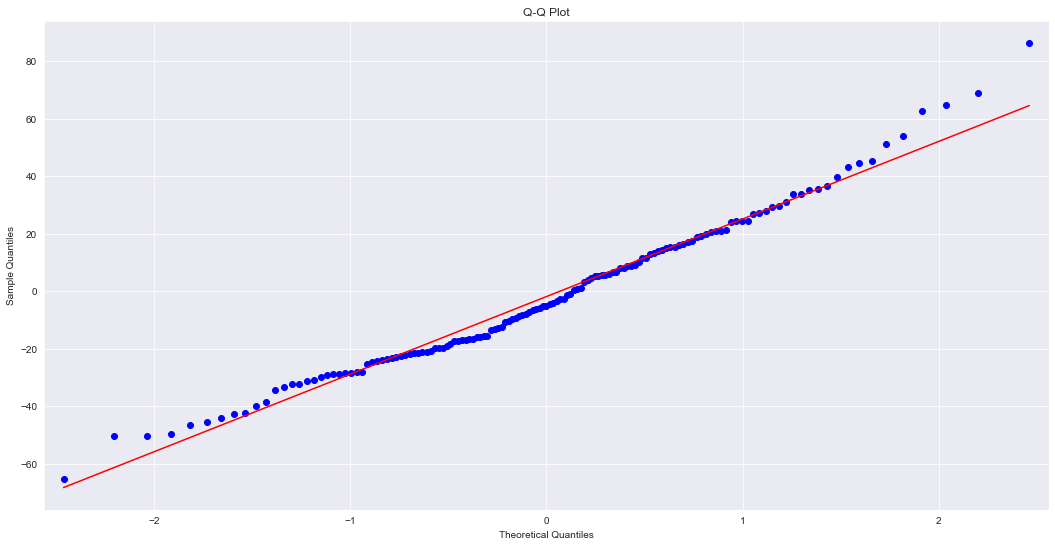

------------------------------------------------------------------------------
Mean of Residuals
-1.8722825473259528
------------------------------------------------------------------------------
Autocorrelation Test
Durbin-Watson Test Result
2.06930355212431
------------------------------------------------------------------------------
Breusch Godfrey Test
                                              0
Breusch Godfrey Test                      Value
Lagrange multiplier test statistic      114.918
p-value Lagrange multiplier test    2.02274e-18
fstatistic                              40.6078
p-value Ftest                       3.17087e-39
------------------------------------------------------------------------------


C:\Users\mehul\Anaconda3\lib\site-packages\ipykernel_launcher.py:161: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


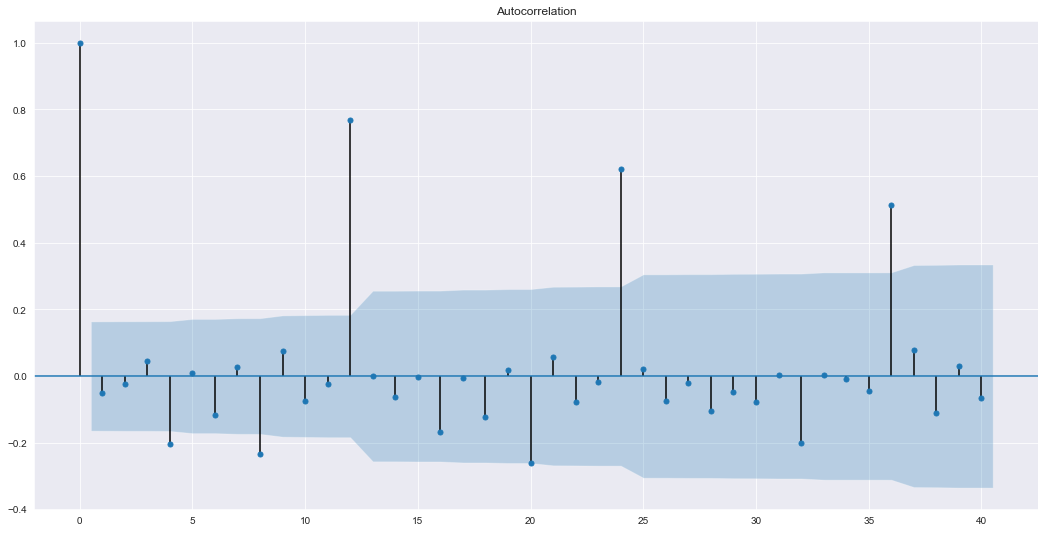

------------------------------------------------------------------------------


In [172]:
linear_model("AirPassengers.csv",3,"Passengers",(2,1,1))

<h3> Performance & Assumption Testing Linear Regression Model  </h3>

First Few Obeservations in Dataset
      crim    zn  indus  chas    nox     rm    age     dis  rad    tax  \
0  0.00632  18.0   2.31     0  0.538  6.575   65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421   78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185   61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998   45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147   54.2  6.0622    3  222.0   
5  0.02985   0.0   2.18     0  0.458  6.430   58.7  6.0622    3  222.0   
6  0.08829  12.5   7.87     0  0.524  6.012   66.6  5.5605    5  311.0   
7  0.14455  12.5   7.87     0  0.524  6.172   96.1  5.9505    5  311.0   
8  0.21124  12.5   7.87     0  0.524  5.631  100.0  6.0821    5  311.0   
9  0.17004  12.5   7.87     0  0.524  6.004   85.9  6.5921    5  311.0   

   ptratio   black  lstat  medv  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  39

C:\Users\mehul\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)



------------------------------------------------------------------------------
Mean Absolute Perecentage Error
16.56612950772788
------------------------------------------------------------------------------
Normality of Residuals
Jarque Bera Test ------- Statistic :458.2698,P_value :0.0000
Shapiro-Wilk Test ------- Statistic :0.9067,P_value :0.0000
Kolmogrov-Smirnov Test ------- Statistic :0.3511,P_value :0.0000
Anderson-Darling Test ------- Statistic :7.5736,5% Critical Value :0.7780


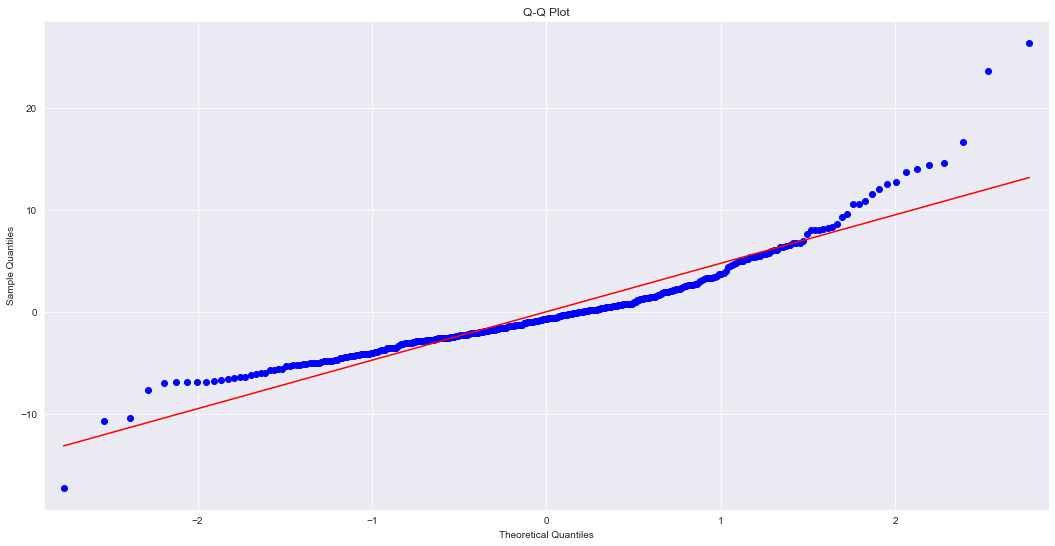

------------------------------------------------------------------------------
Hetroscedasticity Test Results

 Breusch-Pagan test ----
  Breusch-Pagan test  Lagrange multiplier statistic   p-value   f-value  \
0              Value                      50.563016  0.000002  4.358128   

      f p-value  
0  8.222557e-07  

 Goldfeld-Quandt test ----
                value
F statistic  0.782794
p-value      0.940491

 Residuals plots ----


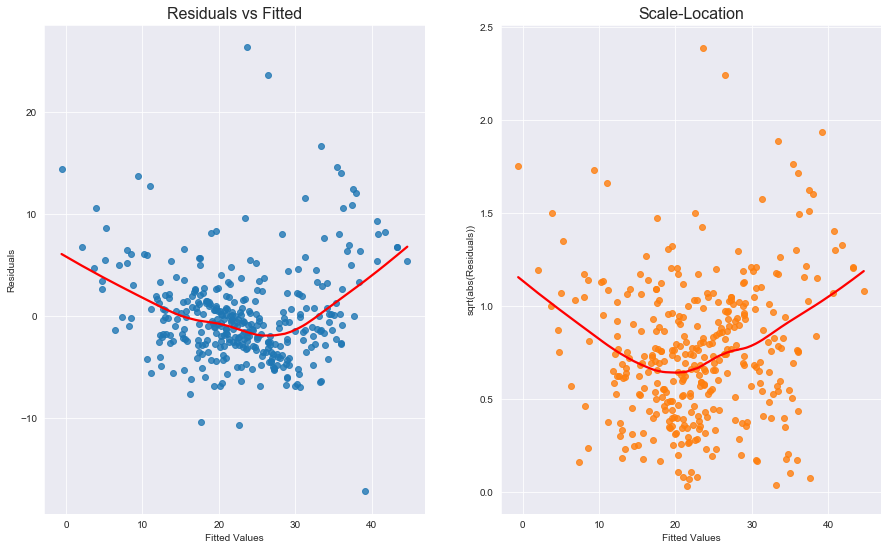

------------------------------------------------------------------------------
Autocorrelation Test
Durbin-Watson Test Result
2.086651903890555
------------------------------------------------------------------------------
Breusch Godfrey Test
                                           0
Breusch Godfrey Test                   Value
Lagrange multiplier test statistic   15.8775
p-value Lagrange multiplier test    0.461546
fstatistic                          0.950893
p-value Ftest                        0.51103
------------------------------------------------------------------------------


C:\Users\mehul\Anaconda3\lib\site-packages\ipykernel_launcher.py:161: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


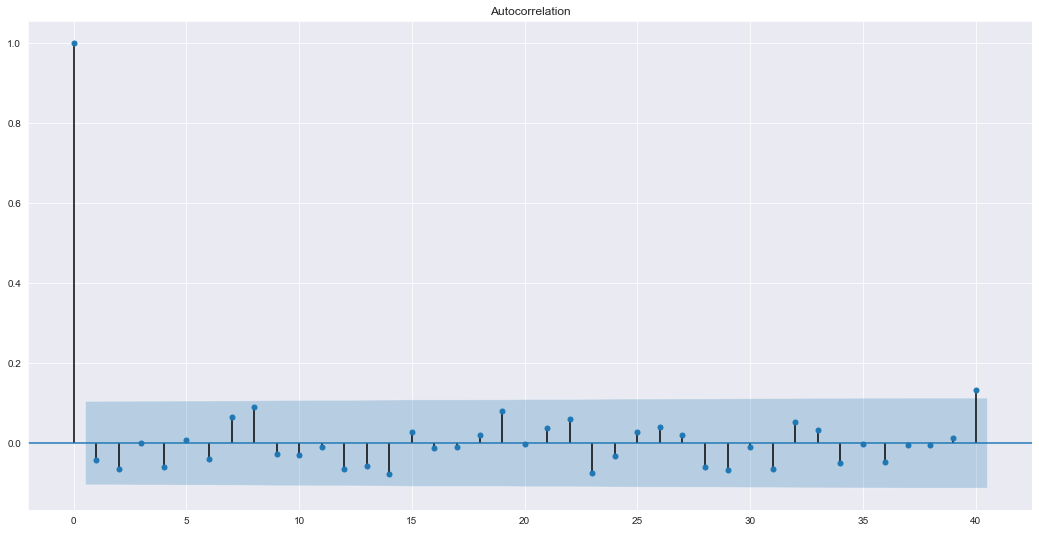

------------------------------------------------------------------------------
Multicollinearity Test
                0
crim     1.731586
zn       2.394452
indus    3.836487
chas     1.102642
nox      4.627219
rm       1.913056
age      2.996110
dis      3.971023
rad      7.534681
tax      8.879471
ptratio  1.821880
black    1.265533
lstat    2.679332
------------------------------------------------------------------------------
Mean of Residuals
4.0459788689503444e-14
------------------------------------------------------------------------------
Linearity Test Results


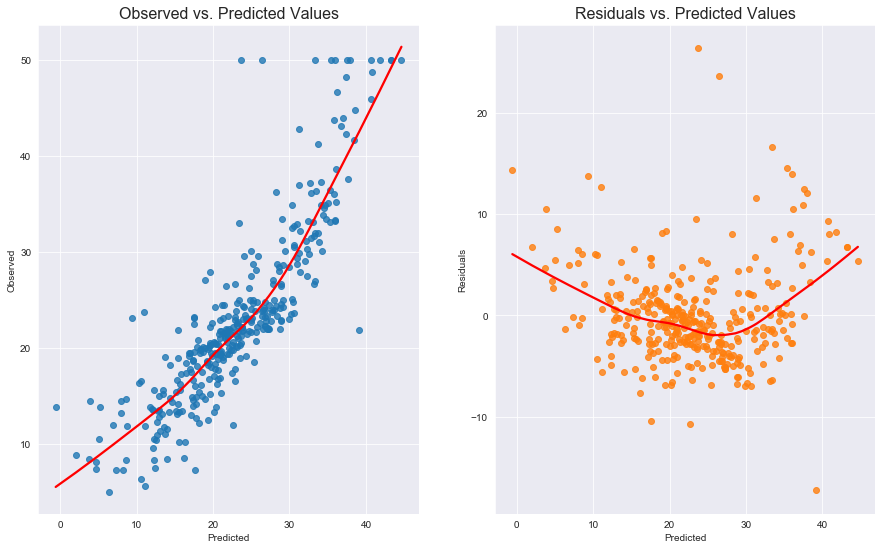

------------------------------------------------------------------------------
Correlation between Independent Variables & Residuals
Variable :crim ---- Correlation:0.0000,P_value:1.0000
Variable :zn ---- Correlation:0.0000,P_value:1.0000
Variable :indus ---- Correlation:0.0000,P_value:1.0000
Variable :chas ---- Correlation:-0.0000,P_value:1.0000
Variable :nox ---- Correlation:0.0000,P_value:1.0000
Variable :rm ---- Correlation:-0.0000,P_value:1.0000
Variable :age ---- Correlation:-0.0000,P_value:1.0000
Variable :dis ---- Correlation:0.0000,P_value:1.0000
Variable :rad ---- Correlation:0.0000,P_value:1.0000
Variable :tax ---- Correlation:0.0000,P_value:1.0000
Variable :ptratio ---- Correlation:0.0000,P_value:1.0000
Variable :black ---- Correlation:-0.0000,P_value:1.0000
Variable :lstat ---- Correlation:0.0000,P_value:1.0000
------------------------------------------------------------------------------
Variability of features
crim          68.957695
zn           509.698402
indus        

In [166]:
linear_model("boston_housing.csv",2,"medv")